In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from rctorchprivate import *#RcTorch import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [2]:
# ! pip install rctorch==0.7162

In [3]:
hi = np.array([[1,2,3], [4,5,6] , [7,8,9]])
hi.reshape(-1,)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
lineW = 3
lineBoxW=2
plt.rcParams['text.usetex'] = True

### This notebook demonstrates how to use RcTorch to find optimal hyper-paramters for the differential equation $\dot y + q(t) y = f(t) $.

Simple population:  <font color='blue'>$\dot y + y =0$  </font>
* Analytical solution: <font color='green'>$y = y_0 e^{-t}$</font>

In [5]:
#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot
def convert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    Returns
    -------
    ode_coefs
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t, ]:
            pass
#         else:
#             assert False, f"{type(coef)} {coef} ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs

In [6]:
def plot_predictions(RC, results, integrator_model, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu()
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = y.cpu()
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, color = "dodgerblue", label = labels[0], linewidth = lineW + 1, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1],  linewidth = lineW)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

def covert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    Returns
    -------
    ode_coefs
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs

def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    Returns
    -------
    None
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = y.cpu()
        ydot = ydot.cpu()
        
        ode_coefs = convert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
            label = r'{Individual Trajectory RMSR}'
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
            label = None
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, color = "orangered", alpha = 0.4, label = label, linewidth = lineW-1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
    print(f"mean_resid {mean_resid.mean()}")
    ax.plot(X, rmsr, 
               color = "blue", 
               alpha = 0.9, 
               label = r'{RMSR}',
               linewidth = lineW-0.5)

    ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')

In [7]:
# common cv arguments:
cv_declaration_args = {"interactive" : False, 
                       "n_jobs" : 8, #"batch_size" : 8, #batch size is parallel
                       "cv_samples" : 1, #number of cv_samples, random start points
                       "initial_samples" : 50, #number of random samples before optimization starts
                       "validate_fraction" : 0.3, #validation prop of tr+val sets
                       "log_score" : False,#True, #log-residuals
                       "random_seed" : 209, # random seed
                       "ODE_order" : 1, #order of eq
                       #see turbo ref:
                       "n_outputs" : 1,
                       "n_inputs" : 1,
                       "length_min" : 2 ** (-11),#2 **(-7), 
                       "success_tolerance" : 3}

## task 1: cross check burn in for all three experiments (burn in should be embedded into hps)


In [8]:
def driven_force(X, A = 1):
    """ a force function, specifically f(t) = sin(t)
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, a torch.tensor of equal dimension to the input time tensor.
    """
    return A*torch.sin(X)

def no_force(X):
    """ a force function (returns 0)
    
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, in this case 0.
    """
    return 0

lam =1
def custom_loss(X , y, ydot, out_weights, lam = lam, force_t = None, reg = False, 
               ode_coefs = None, init_conds = None, 
                enet_alpha = None, enet_strength =None, mean = True):
    """ The loss function of the ODE (in this case the population equation loss)
    Parameters
    ----------
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
        
    Returns
    -------
    the residuals or the cost depending on the mean argument (see above)
    """
    #with paramization
    lam = ode_coefs[0]
    L =  ydot  + lam * y - force_t
    
#     if reg:
#         #assert False
#         weight_size_sq = torch.mean(torch.square(out_weights))
#         weight_size_L1 = torch.mean(torch.abs(out_weights))
#         L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
#         L = L + 0.1 * L_reg 
    
    L = torch.square(L)
    if mean:
        L = torch.mean(L)
    return L

In [9]:
RUN_SIMPLE_POP = False
RUN_DRIVEN_POP = False
RUN_t2 = True

In [10]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(0.1, 2.1, 0.1)
len(y0s)

20

### Simple population

In [11]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.
bounds_dict = {"connectivity" : (-2.2, -0.12), #log space
               "spectral_radius" : (1, 10), #lin space
               "n_nodes" : (250, 250.1), 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0, 1),    #linear space
               "dt" : -2.5, #log space
               "bias": (-0.75,0.75) #linear space
               }

#set up data
x0, xf = 0, 5
nsteps = int(abs(xf - x0)/(10**bounds_dict["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
int(xtrain.shape[0] * 0.5)

790

In [12]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
if RUN_SIMPLE_POP:
    esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                                esn_burn_in = 500, #states to throw away before calculating output
                                subsequence_prop = 0.8, #combine len of tr + val sets
                                **cv_declaration_args
                                )
    #optimize the network:
    simple_pop_hps = esn_cv.optimize(x = xtrain,
                              reparam_f = reparam, 
                              ODE_criterion = custom_loss,
                              init_conditions = [y0s], 
                              force = no_force,
                              ode_coefs = [1, 1],
                              max_evals = 500,
                              n_trust_regions = 2,
                              reg_type = "simple_pop")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [13]:
if RUN_SIMPLE_POP:
    simple_pop_hps = esn_cv.recover_hps()
    simple_pop_hps

In [14]:
%%time
if RUN_SIMPLE_POP:
    pop_RC = EchoStateNetwork(**simple_pop_hps,
                             random_state = 209, 
                             dtype = torch.float32)

    train_args = {"X" : xtrain.view(-1,1),        
                  "burn_in" : 500, 
                  "ODE_order" : 1,   
                  "force" : no_force, 
                  "reparam_f" : reparam,
                  "ode_coefs" : [1, 1]}


    pop_results = pop_RC.fit(init_conditions = [y0s,1],
                            SOLVE = True,
                            train_score = True, 
                            ODE_criterion = custom_loss,

                             n_outputs = 1,
                            **train_args)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [15]:
def simple_pop(y, t, t_pow = 0, force_k = 0, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

In [16]:
#TODO: show results outside BO range

In [17]:
# some particularly good runs:

# simple_pop_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 250,
#  'connectivity': 0.13615401772200952,
#  'spectral_radius': 4.1387834548950195,
#  'regularization': 0.00028325262824591835,
#  'leaking_rate': 0.2962796092033386,
#  'bias': -0.5639935731887817}

# opt_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 250,
#  'connectivity': 0.7170604557008349,
#  'spectral_radius': 1.5755887031555176,
#  'regularization': 0.00034441529823729916,
#  'leaking_rate': 0.9272222518920898,
#  'bias': 0.1780446171760559}

# opt_hps = {'dt': 0.0017782794100389228,
#  'n_nodes': 250,
#  'connectivity': 0.11197846061157432,
#  'spectral_radius': 1.7452095746994019,
#  'regularization': 0.00012929296298723957,
#  'leaking_rate': 0.7733328938484192,
#  'bias': 0.1652531623840332}

In [18]:

if RUN_SIMPLE_POP:
    fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
    ax = plt.subplot(gs1[:-1, :])

    gts = plot_predictions(RC = pop_RC, 
                           results = pop_results, 
                           integrator_model = simple_pop, 
                           ax = ax)

    ax = plt.subplot(gs1[-1, :])
    plot_data = plot_rmsr(pop_RC, 
                          results = pop_results, 
                          force = no_force, 
                          ax = ax)

In [19]:
#esn_cv.X_turbo[0,:]

In [20]:
#plt.plot(-esn_cv.Y_turbo)

### Driven population:

In [21]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.
bounds_dict = {"connectivity" : (-2, -0.12), #log space
               "spectral_radius" : (1, 10), #lin space
               "n_nodes" : 400, 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0, 1),    #linear space
               "dt" : -2.5, #log space
               "bias": (-0.75,0.75) #linear space
               }

In [22]:
%%time
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
if RUN_DRIVEN_POP:
    esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                                esn_burn_in = 500, #states to throw away before calculating output
                                subsequence_prop = 0.8, #combine len of tr + val sets
                                **cv_declaration_args,

                                )
    #optimize the network:
    driven_pop_hps = esn_cv.optimize(x = xtrain,
                              reparam_f = reparam, 
                              ODE_criterion = custom_loss,
                              init_conditions = [y0s], 
                              force = driven_force,
                              ode_coefs = [1, 1],
                              reg_type = "driven_pop")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [23]:
y0s = np.arange(-10, 10.1, 1)
len(y0s)

21

In [24]:
%%time
if RUN_DRIVEN_POP:
    driven_RC = EchoStateNetwork(**driven_pop_hps,
                             random_state = 209, 
                             dtype = torch.float32)

    train_args = {"X" : xtrain.view(-1,1),        
                  "burn_in" : 500, 
                  "ODE_order" : 1,   
                  "force" : driven_force, 
                  "reparam_f" : reparam,
                  "ode_coefs" : [1, 1]}


    driven_results = driven_RC.fit(init_conditions = [y0s,1],
                        SOLVE = True,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        **train_args)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [25]:
def driven_pop(y, t, t_pow = 0, force_k = 1, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt


In [26]:
if RUN_DRIVEN_POP:
    driven_pop_hps

In [27]:
if RUN_DRIVEN_POP:
    fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
    ax = plt.subplot(gs1[:-1, :])

    gts = plot_predictions(RC = driven_RC, 
                           results = driven_results, 
                           integrator_model = driven_pop, 
                           ax = ax)

    ax = plt.subplot(gs1[-1, :])
    plot_data = plot_rmsr(driven_RC, 
                          results = driven_results, 
                          force = driven_force, 
                          ax = ax)

#### Driven t^2 Population:

In [28]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(-10, 10.1, 0.1)
len(y0s)

201

In [29]:
np.log10(0.5)

-0.3010299956639812

In [30]:
t2_hps =  {'n_nodes': 500,
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.05,#0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005,
           'input_connectivity' : 0.3}

In [203]:
#declare the bounds dict. We search for the variables within the specified bounds.
# if a variable is declared as a float or integer like n_nodes or dt, these variables are fixed.

t2_hps =  {'n_nodes': (500, 503),
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005}

bounds_dict = {"connectivity" : (-1.2, -0.8), #log space
               "spectral_radius" : (1.5, 1.89), #lin space
               "n_nodes" : 500, 
               "regularization" : (-4, 4), #log space
               "leaking_rate" : (0.01, 1.0),#(0.02, .04),    #linear space
               "dt" : -2.3, #log space
               "bias": (-1,1), #linear space
               'feedback_connectivity' : (0,1),
               #'input_connectivity' : (0,1),
               'input_scaling' : 0.0, #(0.1, 2),
               'feedback_scaling' :(0.1, 2),
               'feedback' : 1
               }

In [209]:
hi = {"relu" : 0.3, "tanh" : 0.8}
list(zip(*hi))

[('r', 't'), ('e', 'a'), ('l', 'n'), ('u', 'h')]

In [214]:
torch.tensor(np.random.choice(list(range(3)), size = 10, p = [0.1, 0.1, 0.8])) 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [205]:
%%time
n = 8
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
#for more information see the github.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            esn_burn_in = 0, #states to throw away before calculating output
                            subsequence_prop = 0.8, #combine len of tr + val sets
                            **cv_declaration_args,
                            solve_sample_prop = 0.5,
                            activation_function = {"relu"}
                            )
#optimize the network:
opt = True
if opt:
    t2_pop_hps = esn_cv.optimize(x = xtrain,
                              reparam_f = reparam, 
                              ODE_criterion = custom_loss,
                              init_conditions = [y0s], 
                              force = driven_force,
                              ode_coefs = ["t^2", 1],
                              max_evals = 200 * n,
                              n_trust_regions = n,
                              reg_type = "driven_pop")

FEEDBACK: None , device: None
cpu
m,n 1 500
in_weights torch.Size([500, 1]) m 1 n_in 1
Model initialization and exploration run...


KeyboardInterrupt: 

In [108]:
def recover_hps(self, alternative_index = None):
        if alternative_index or alternative_index == 0:
            _, best_indices = self.Y_turbo.view(-1,).topk(len(self.Y_turbo))
            #breakpoint()
            #I'm too lazy to change this now but best_vals will refer to the selected hps to "recover"
            best_vals = self.X_turbo[best_indices[alternative_index]]
        else:
            best_vals = self.X_turbo[torch.argmax(self.Y_turbo)]
            
        denormed_ = self.denormalize_bounds(best_vals)

        try:
            denormed_ = denormalize_bounds(best_vals)
        except:
            print("FAIL")

        #best_vals = X_turbo[torch.argmax(Y_turbo)]

        #####Bad temporary code to change it back into a dictionaryf
        denormed_free_parameters = list(zip(self.free_parameters, denormed_))
        denormed_free_parameters = dict([ (item[0], item[1].item()) for item in denormed_free_parameters])

        best_hyper_parameters = denormed_free_parameters
        for fixed_parameter in self.fixed_parameters:
            best_hyper_parameters = {fixed_parameter : self.bounds[fixed_parameter], **best_hyper_parameters }

        #log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']
        for var in self.log_vars:
            if var in best_hyper_parameters:
                best_hyper_parameters[var] = 10. ** best_hyper_parameters[var] 



        # Return best parameters
        return best_hyper_parameters


In [109]:

#solution run:
t2_hps =  {'n_nodes': 500,
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.05,#0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005,
           'input_connectivity' : 0.3}

In [110]:
#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(-10, 10.1, 0.1)
len(y0s)

201

In [111]:
#max(esn_cv.Y_turbo)

In [112]:
import seaborn as sns

In [113]:
#df = pd.DataFrame({"Y" : esn_cv.Y_turbo.view(-1,), "turbo_id" :  esn_cv._idx.view(-1,)})
# sub_df = df.loc[df["turbo_id"] == -1]

# plt.plot(range(len(sub_df)), sub_df.Y, color = "red", alpha = 0.4)

In [114]:
# for i in range(len(df.turbo_id.unique())):
# #     if i > 3:
# #         break
#     sub_df = df.loc[df["turbo_id"] == i]
#     plt.plot(range(len(sub_df)), sub_df.Y, color = "red", alpha = 0.4)

In [115]:
#sns.lineplot(x = range(len(df)), y = "Y", data = df, hue = "turbo_id")

FAIL
{'feedback': 1, 'dt': 0.005011872336272725, 'n_nodes': 500, 'spectral_radius': 1.89, 'connectivity': 0.1, 'regularization': 26.06307408848708, 'leaking_rate': 0.03024485521018505, 'bias': 0.9432246685028076, 'feedback_connectivity': 0.017625024542212486, 'input_connectivity': 0.26556336879730225, 'input_scaling': 0.6623784899711609, 'feedback_scaling': 0.37480247020721436}


In [186]:
# t2_hps =  {'n_nodes': 500,
#            'connectivity': 0.09905712745750006,
#            'spectral_radius': 1.8904799222946167,
#            'regularization': 714.156090350679,
#            'leaking_rate': 0.031645022332668304,
#            'bias': -0.24167031049728394,
#            'dt' : 0.005,
#            'input_connectivity' : 0.01}

# t2_hps =  {'n_nodes': 500,
#            'connectivity': 0.09905712745750006,
#            'spectral_radius': 1.8904799222946167,
#            'regularization': 714.156090350679,
#            'leaking_rate': 0.031645022332668304,
#            'bias': -0.24167031049728394,
#            'dt' : 0.005,
#            'feedback' : 0} 
#            'input_scaling' :0.0,
#            'feedback_scaling' :0.3,
#            'input_connectivity' : 0.2,
#            'feedback_connectivity' : 0.2}

In [187]:
pow_ = 2



def t2_pop(y, t, t_pow = pow_, force_k = 1, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

In [198]:
%%time

t2_hps = recover_hps(esn_cv, 2)
t2_hps["input_scaling"] =  0.0
#t2_hps["spectral_radius"] = 0.99
print(t2_hps)

#t2_hps["leaking_rate"] =0.1
# t2_hps["spectral_radius"] = 1.3#1.5

#declare the initial conditions (each initial condition corresponds to a different curve)
y0s = np.arange(-2, 2.9, 0.25)
len(y0s)

#t2_hps["input_connectivity"] = 1.0
t2_RC = EchoStateNetwork(**t2_hps,#pop_hps,
                         random_state = 209, 
                         #feedback = True,
                         dtype = torch.float32, )

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : 0, #1000, 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [f"t**{pow_}", 1]}


t2_results = t2_RC.fit(init_conditions = [y0s,1],
                        SOLVE = True,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        
                        #backprop_f = optimize_last_layer,
                        **train_args,
                        n_outputs = 1)

FAIL
{'feedback': 1, 'dt': 0.005011872336272725, 'n_nodes': 500, 'spectral_radius': 1.89, 'connectivity': 0.1, 'regularization': 26.06307408848708, 'leaking_rate': 0.03024485521018505, 'bias': 0.9432246685028076, 'feedback_connectivity': 0.017625024542212486, 'input_connectivity': 0.26556336879730225, 'input_scaling': 0.0, 'feedback_scaling': 0.37480247020721436}
CPU times: user 1.28 s, sys: 120 ms, total: 1.4 s
Wall time: 1.35 s


In [199]:
esn_cv.log_vars

['connectivity',
 'llambda',
 'llambda2',
 'enet_strength',
 'noise',
 'regularization',
 'dt',
 'gamma_cyclic',
 'sigma']

In [200]:
np.log10(0.09905712745750006)

-1.0041142702102661

In [201]:
np.mean(t2_results['scores'])

0.040925182

alterning ode_coefs
mean_resid 0.04092518240213394


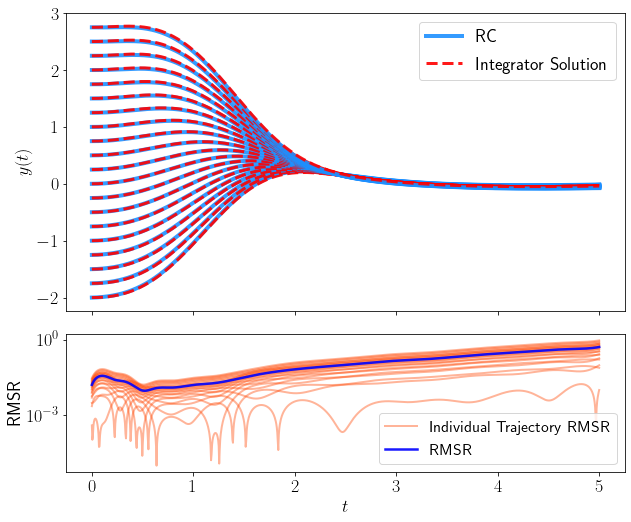

In [202]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = t2_RC, 
                       results = t2_results, 
                       integrator_model = t2_pop, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(t2_RC, 
                      results = t2_results, 
                      force = driven_force, 
                      ax = ax)

In [ ]:
# X_turbo = pd.DataFrame(esn_cv.X_turbo.numpy())
# X_turbo.columns = esn_cv.free_parameters
# Y_turbo = pd.DataFrame(esn_cv.Y_turbo.numpy())
# Y_turbo.to_csv("driven_force_Y_turbo.csv")
# X_turbo.to_csv("driven_force_X_turbo.csv")

In [ ]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

In [ ]:

def force(X, A = 0):
    return torch.zeros_like(X)

def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 0,
                        epochs = 30000,
                        custom_loss = custom_loss,
                        #loss_threshold = 10 ** -8,
                        EPOCHS_TO_TERMINATION = None,
                        force = force,
                        learning_rate = 0.01,
                        plott = False,
                        spikethreshold = 0.25):
    #define new_x
    new_X = esn.extended_states.detach()

    #force detach states_dot
    esn.states_dot = esn.states_dot.detach().requires_grad_(False)

    #define criterion
    criterion = torch.nn.MSELoss()
    
    try:
        assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
    except:
        esn.LinOut.weight.requires_grad_(True)
        esn.LinOut.bias.requires_grad_(True)
    #define previous_loss (could be used to do a convergence stop)
    previous_loss = 0

    #define best score so that we can save the best weights
    best_score = 0

    #define the optimizer
    optimizer = optim.Adam(esn.parameters(), lr = learning_rate)

    #define the loss history
    loss_history = []
    
    if plott:
        #use pl for live plotting
        fig, ax = pl.subplots(1,3, figsize = (16,4))
    
    t = esn.X#.view(*N.shape).detach()
    g, g_dot = esn.G
    y0  = esn.init_conds[0]
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    lrs = []
    
    floss_last = 0
    force_t = force(t)

    #begin optimization loop
    for e in range(epochs):

        optimizer.zero_grad()
        
        N = esn.forward( esn.extended_states )
        N_dot = esn.calc_Ndot(esn.states_dot)

        y = y0  + g *N 
        
        ydot = g_dot * N + g * N_dot

        #assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'
        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        
        #assert False, f'{esn.LinOut.weight}'

        total_ws = esn.LinOut.weight.shape[0] + 1
        weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))
        
        loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = False, ode_coefs = esn.ode_coefs, force_t = force_t)
        loss.backward()
        optimizer.step()
        floss = float(loss)
        loss_history.append(floss)
        
        if not e and not best_score:
            best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()

        #if e > SAVE_AFTER_EPOCHS:
        if not best_score:
            best_score = float(loss)
            if floss <= min(loss_history):
                best_pred = y.clone()
                best_ydot = ydot.clone()
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
        else:
            if floss < best_score:
                best_pred = y.clone()
                best_ydot = ydot.clone()
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                best_score = float(loss)
                
        if EPOCHS_TO_TERMINATION:
            if e >= EPOCHS_TO_TERMINATION:
                backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
                return {"weights": best_weight, 
                        "best_score" : torch.tensor(best_score),
                        "bias" : best_bias, 
                        "loss" : backprop_args,
                        "ydot" : best_ydot, 
                        "y" : best_pred}
            
        if e > 1:
            if float(np.log(floss_last) - np.log(floss)) > spikethreshold:
                lrs.append(optimizer.param_groups[0]["lr"])
                scheduler.step()
                #for param_group in optimizer.param_groups:
                #    print('lr', param_group['lr'])
        floss_last = floss
        if plott:

            if e % 1500 == 0:
                ax[0].clear()
                logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                print(logloss_str + ", " + delta_loss)
                ax[0].plot(N.detach().cpu(), label = "exact")
                ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                ax[0].set_xlabel("epochs")

                ax[1].set_title(delta_loss)
                ax[1].plot(N_dot.detach().cpu())
                #ax[0].plot(y_dot.detach(), label = "dy_dx")
                ax[2].clear()
                weight_size = str(weight_size_sq.detach().item())
                ax[2].set_title("loss history \n and "+ weight_size)

                ax[2].loglog(loss_history)

                [ax[i].legend() for i in range(3)]
                previous_loss = loss.item()

                #clear the plot outputt and then re-plot
                display.clear_output(wait=True) 
                display.display(pl.gcf())
    backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
    return {"weights": best_weight, 
            "bias" : best_bias, 
            "loss" : backprop_args,
            "ydot" : best_ydot,
            "best_score" : torch.tensor(best_score), 
            "y" : best_pred}